### 作业四：图像生成
本次作业目的是让同学们体验使用GAN模型进行图像生成，训练一个随机噪声和类别标签映射为数字图片的Conditional GAN模型，并由自己的学号生成一个手写数字序列

需要完成的内容
- 补全TODO标记的内容
- 试着自己调整网络结构、损失函数等，看看不同网络的效果。

需要提交的内容
- 补全后的代码（.ipynb文件），只需要提交初始版本。
- 实验报告，要求包含生成的数字序列和简单的实验总结。


In [1]:
import jittor as jt
from jittor import init
import argparse
import os
import numpy as np
import math
from jittor import nn

jt.flags.use_cuda = 1

# number of epochs of training
n_epochs = 10
# size of the batches
batch_size = 16
# adam: learning rate
lr = 0.0002
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# number of cpu threads to use during batch generation
n_cpu = 8
# dimensionality of the latent space
latent_dim = 100
# number of classes for dataset
n_classes = 10
# size of each image dimension
img_size = 32
# number of image channels
channels = 1
# interval between image sampling
sample_interval = 10000

# 图像尺寸
img_shape = (channels, img_size, img_size)

# 使用 BCE 损失，反卷积 Generator
use_bce_loss = True
use_deconv_generator = True

[i 1130 16:12:10.140248 00 lock.py:85] Create lock file:/root/.cache/jittor/jt1.3.10/g++12.4.0/py3.8.20/Linux-5.15.0-1x9e/AMDEPYC754232-x57/176f/jittor.lock
[i 1130 16:12:10.167323 00 compiler.py:956] Jittor(1.3.10.0) src: /root/miniconda3/envs/ai_course/lib/python3.8/site-packages/jittor
[i 1130 16:12:10.175900 00 compiler.py:957] g++ at /usr/bin/g++(12.4.0)
[i 1130 16:12:10.176021 00 compiler.py:958] cache_path: /root/.cache/jittor/jt1.3.10/g++12.4.0/py3.8.20/Linux-5.15.0-1x9e/AMDEPYC754232-x57/176f/default
[i 1130 16:12:10.240629 00 install_cuda.py:96] cuda_driver_version: [12, 4]
[i 1130 16:12:10.240990 00 install_cuda.py:82] needed restart but not /root/miniconda3/envs/ai_course/bin/python ['-m', 'ipykernel_launcher', '--f=/root/.local/share/jupyter/runtime/kernel-v3094eadfda6f92e5805fb5673672f1ac2f8addc7b.json'], you can ignore this warning.
[i 1130 16:12:10.278044 00 __init__.py:412] Found /root/.cache/jittor/jtcuda/cuda12.2_cudnn8_linux/bin/nvcc(12.2.140) at /root/.cache/jittor

[i 1130 16:12:18.328419 12 log.cc:351] Load log_sync: 1
[i 1130 16:12:34.216660 12 __init__.py:227] Total mem: 503.72GB, using 16 procs for compiling.


[i 1130 16:13:09.695536 12 log.cc:351] Load log_sync: 1
[i 1130 16:13:09.697108 12 jit_compiler.cc:28] Load cc_path: /usr/bin/g++


Compiling jittor_core(151/151) used: 34.849s eta: 0.000s


[i 1130 16:13:09.993400 12 init.cc:63] Found cuda archs: [89,]
[i 1130 16:13:10.050870 12 compile_extern.py:388] Downloading cutt...
[i 1130 16:13:10.104816 12 compile_extern.py:401] installing cutt...


[i 1130 16:13:19.947734 12 compiler.py:34] Create cache dir: /root/.cache/jittor/jt1.3.10/g++12.4.0/py3.8.20/Linux-5.15.0-1x9e/AMDEPYC754232-x57/176f/default/cu12.2.140_sm_89/custom_ops


Compiling libcutt(9/9) used: 9.729s eta: 0.000s


[i 1130 16:13:25.277854 12 compiler.py:34] Create cache dir: /root/.cache/jittor/jt1.3.10/g++12.4.0/py3.8.20/Linux-5.15.0-1x9e/AMDEPYC754232-x57/176f/default/cu12.2.140_sm_89/cuda


Compiling gen_ops_mkl_conv_backward_x_mkl_conv_backward_w_mk___hashbc87cd(7/7) used: 3.328s eta: 0.000s
Compiling gen_ops_cub_where_cub_test_cub_cumsum_cub_arg_redu___hash7af395(6/6) used: 2.250s eta: 0.000s
Compiling gen_ops_cudnn_rnn_cudnn_conv3d_cudnn_rnn_backward____hash4a5ca9(16/16) used: 5.476s eta: 0.000s


[i 1130 16:13:42.276711 12 cuda_flags.cc:55] CUDA enabled.


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.init_size = img_size // 4  # 预先升维到 8x8
        self.l1 = nn.Linear(latent_dim + n_classes, 128 * self.init_size ** 2)
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def execute(self, noise, labels):
        gen_input = jt.contrib.concat((self.label_emb(labels), noise), dim=1)
        out = self.l1(gen_input)
        out = out.view((out.shape[0], 128, self.init_size, self.init_size))
        img = self.conv_blocks(out)
        return img
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)) + n_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def execute(self, img, labels):
        d_in = jt.contrib.concat((img.view((img.shape[0], -1)), self.label_embedding(labels)), dim=1)
        validity = self.model(d_in)
        return validity

# 损失函数
adversarial_loss = nn.BCELoss() if use_bce_loss else nn.MSELoss()

generator = Generator()
discriminator = Discriminator()

In [3]:

import os
os.system("mkdir -p ~/.cache/jittor/dataset/mnist_data")
os.system("wget -O ~/.cache/jittor/dataset/mnist_data/train-labels-idx1-ubyte.gz 'https://cloud.tsinghua.edu.cn/f/b51b2b75cb03408e99be/?dl=1'")
os.system("wget -O ~/.cache/jittor/dataset/mnist_data/train-images-idx3-ubyte.gz 'https://cloud.tsinghua.edu.cn/f/6a88440968b84630bb71/?dl=1'")
os.system("wget -O ~/.cache/jittor/dataset/mnist_data/t10k-images-idx3-ubyte.gz 'https://cloud.tsinghua.edu.cn/f/f17348dfafbd420d8dee/?dl=1'")
os.system("wget -O ~/.cache/jittor/dataset/mnist_data/t10k-labels-idx1-ubyte.gz 'https://cloud.tsinghua.edu.cn/f/3b34d4ad70db4c34bb4c/?dl=1'")

--2025-11-30 16:13:59--  https://cloud.tsinghua.edu.cn/f/b51b2b75cb03408e99be/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.15.69, 2402:f000:1:402:101:6:15:69
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.15.69|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/2de830f0-e021-4bb2-a9bc-9ad86a3b9321/train-labels-idx1-ubyte.gz [following]
--2025-11-30 16:13:59--  https://cloud.tsinghua.edu.cn/seafhttp/files/2de830f0-e021-4bb2-a9bc-9ad86a3b9321/train-labels-idx1-ubyte.gz
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/octet-stream]
Saving to: ‘/root/.cache/jittor/dataset/mnist_data/train-labels-idx1-ubyte.gz’

     0K .......... .......... ........                        100%  495K=0.06s

2025-11-30 16:13:59 (495 KB/s) - ‘/root/.cache/jittor/dataset/mnist_data/train-labels-idx1-ubyte.g

0

In [4]:
from jittor.dataset.mnist import MNIST
import jittor.transform as transform

transform_fn = transform.Compose([
    transform.Resize(img_size),
    transform.Gray(),
    transform.ImageNormalize(mean=[0.5], std=[0.5])
])

dataloader = MNIST(download=True, train=True, transform=transform_fn).set_attrs(batch_size=batch_size, shuffle=True)

generator = Generator()
discriminator = Discriminator()
optimizer_G = nn.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = nn.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [7]:
from PIL import Image
import numpy as np

def save_image(img, path, nrow=10, padding=2):
    N, C, W, H = img.shape
    ncol = N // nrow
    if isinstance(img, jt.Var):
        img = img.data  # 转为 numpy
    img = ((img + 1)/2*255).clip(0,255)
    img_grid = np.zeros((C, nrow*W + (nrow-1)*padding, ncol*H + (ncol-1)*padding))
    
    for i in range(nrow):
        for j in range(ncol):
            img_grid[:, i*W + i*padding:(i+1)*W + i*padding, j*H + j*padding:(j+1)*H + j*padding] = img[i*ncol + j]
    
    if C == 1:
        img_grid = img_grid[0]
    Image.fromarray(img_grid.astype(np.uint8)).save(path)

def sample_image(n_row, batches_done):
    # 随机采样输入并保存生成的图片
    z = jt.array(np.random.normal(0, 1, (n_row ** 2, latent_dim))).float32().stop_grad()
    labels = jt.array(np.array([num for _ in range(n_row) for num in range(n_row)])).float32().stop_grad()
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.numpy(), "%d.png" % batches_done, nrow=n_row)

In [11]:
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size_i = imgs.shape[0]
        valid = jt.ones([batch_size_i, 1]).float32()
        fake = jt.zeros([batch_size_i, 1]).float32()

        real_imgs = jt.array(imgs)
        labels = jt.array(labels)

        # 训练 Generator
        z = jt.array(np.random.normal(0, 1, (batch_size_i, latent_dim))).float32()
        gen_labels = jt.array(np.random.randint(0, n_classes, batch_size_i)).float32()
        gen_imgs = generator(z, gen_labels)
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        g_loss.sync()
        optimizer_G.step(g_loss)

        # 训练 Discriminator
        validity_real = discriminator(real_imgs, labels)
        validity_fake = discriminator(gen_imgs.stop_grad(), gen_labels)
        d_loss = (adversarial_loss(validity_real, valid) + adversarial_loss(validity_fake, fake)) / 2
        d_loss.sync()
        optimizer_D.step(d_loss)

        if i % 50 == 0:
            print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.data.mean():.4f}] [G loss: {g_loss.data.mean():.4f}]")

    # 保存每轮生成图片
    z = jt.array(np.random.normal(0, 1, (25, latent_dim))).float32()
    labels_sample = jt.array(np.arange(0, 25)%10).float32()
    gen_imgs = generator(z, labels_sample)
    save_image(gen_imgs, f"epoch_{epoch}.png", nrow=5)

    # 保存模型
    generator.save('generator_last.pkl')
    discriminator.save('discriminator_last.pkl')

[Epoch 0/10] [Batch 0/3750] [D loss: 0.6871] [G loss: 0.6996]
[Epoch 0/10] [Batch 50/3750] [D loss: 0.6543] [G loss: 0.8185]
[Epoch 0/10] [Batch 100/3750] [D loss: 0.6439] [G loss: 0.8698]
[Epoch 0/10] [Batch 150/3750] [D loss: 0.6917] [G loss: 0.7422]
[Epoch 0/10] [Batch 200/3750] [D loss: 0.6349] [G loss: 0.7953]
[Epoch 0/10] [Batch 250/3750] [D loss: 0.6728] [G loss: 0.7764]
[Epoch 0/10] [Batch 300/3750] [D loss: 0.6901] [G loss: 0.7638]
[Epoch 0/10] [Batch 350/3750] [D loss: 0.6963] [G loss: 0.7395]
[Epoch 0/10] [Batch 400/3750] [D loss: 0.6486] [G loss: 0.7709]
[Epoch 0/10] [Batch 450/3750] [D loss: 0.6945] [G loss: 0.7090]
[Epoch 0/10] [Batch 500/3750] [D loss: 0.6683] [G loss: 0.7429]
[Epoch 0/10] [Batch 550/3750] [D loss: 0.6656] [G loss: 0.7432]
[Epoch 0/10] [Batch 600/3750] [D loss: 0.6806] [G loss: 0.7652]
[Epoch 0/10] [Batch 650/3750] [D loss: 0.6202] [G loss: 0.8458]
[Epoch 0/10] [Batch 700/3750] [D loss: 0.6766] [G loss: 0.8074]
[Epoch 0/10] [Batch 750/3750] [D loss: 0.68

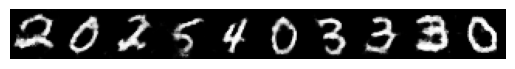

In [17]:
import matplotlib.pyplot as plt
generator.eval()
discriminator.eval()
generator.load('generator_last.pkl')
discriminator.load('discriminator_last.pkl')

number = "2025403330"
n_row = len(number)
z = jt.array(np.random.normal(0, 1, (n_row, latent_dim))).float32().stop_grad()
labels = jt.array(np.array([int(number[num]) for num in range(n_row)])).float32().stop_grad()
gen_imgs = generator(z, labels)

img_array = gen_imgs.data.transpose((1,2,0,3))[0].reshape((gen_imgs.shape[2], -1))
min_ = img_array.min()
max_ = img_array.max()
img_array = (img_array - min_) / (max_ - min_) * 255

fig, ax = plt.subplots()
ax.imshow(img_array, cmap='gray')
ax.axis('off')
fig.patch.set_visible(False)
plt.savefig('result.png')